In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set paths to your dataset
train_dir = "/content/drive/MyDrive/research_pro/own/train"
test_dir = "/content/drive/MyDrive/research_pro/own/valid"

In [4]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

In [5]:
# Data augmentation for training images are converted into array of images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, #rescales pixels val b/w 0 and 1
    rotation_range=10,
    width_shift_range=0.1, #horizontal shift
    height_shift_range=0.1, #vertical shift
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [6]:
# No data augmentation for validation/test images
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [7]:
# Load and prepare training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 197 images belonging to 2 classes.


In [8]:
# Load and prepare test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure the same order as labels for accuracy calculation
)

Found 78 images belonging to 2 classes.


In [9]:
# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False)
#weights='imagenet':initialize the model with pre-trained weights from the ImageNet dataset
#include_top=False: doesnt include fully connected layers; only includes the base-feature extraction layers

83683744/83683744 [==============================] - 0s 0us/step


In [10]:
# Add custom classification layers on top of Xception
x = base_model.output #retrieves the output tensor of the Xception base model
x = GlobalAveragePooling2D()(x) #for dimensionality reduction
x = Dense(128, activation='relu')(x) #fullyconnected dense layer with 128;serves as a hidden layer extracting higher-level features from the output of the previous layers
x = Dropout(0.5)(x)  #Dropout layer on top of the output tensor;prevents overfitting
predictions = Dense(1, activation='sigmoid')(x)#final output layer on top of the output tensor;consists of a single neuron with a sigmoid activation function, which is suitable for binary classification tasks.

In [11]:
# Create model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze Xception layers
for layer in base_model.layers:
    layer.trainable = False # effectively freezing the weights of all layers in the base model;why-the model can focus on learning task-specific features in the custom classification layers added on top, without altering the pre-trained features

In [13]:
# Compile the model
model.compile(optimizeloss=r='adam', 'binary_crossentropy', metrics=['accuracy'])#Adam adapts the learning rates for each parameter during training, making it effective for a wide range of problems.

In [16]:
# Train the model
model.fit(train_generator, epochs=12, validation_data=test_generator)

Epoch 1/12
7/7 [==============================] - 79s 11s/step - loss: 0.1143 - accuracy: 0.9645 - val_loss: 0.1160 - val_accuracy: 0.9487
Epoch 2/12
7/7 [==============================] - 58s 9s/step - loss: 0.1471 - accuracy: 0.9289 - val_loss: 0.1039 - val_accuracy: 0.9359
Epoch 3/12
7/7 [==============================] - 58s 8s/step - loss: 0.1400 - accuracy: 0.9391 - val_loss: 0.1015 - val_accuracy: 0.9359
Epoch 4/12
7/7 [==============================] - 57s 8s/step - loss: 0.1257 - accuracy: 0.9442 - val_loss: 0.0994 - val_accuracy: 0.9487
Epoch 5/12
7/7 [==============================] - 61s 9s/step - loss: 0.1295 - accuracy: 0.9695 - val_loss: 0.0938 - val_accuracy: 0.9487
Epoch 6/12
7/7 [==============================] - 57s 9s/step - loss: 0.1233 - accuracy: 0.9442 - val_loss: 0.0888 - val_accuracy: 0.9487
Epoch 7/12
7/7 [==============================] - 58s 8s/step - loss: 0.1031 - accuracy: 0.9594 - val_loss: 0.0951 - val_accuracy: 0.9487
Epoch 8/12
7/7 [=================

In [17]:
# Predictions on test set
y_pred = model.predict(test_generator) #predictions for the test set using the trained mode
y_pred_binary = np.where(y_pred>0.5,1,0)  # Convert probabilities to binary predictions

3/3 [==============================] - 18s 5s/step


In [18]:
# Get true labels for test set
y_true = test_generator.classes

In [19]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.9743589743589743


1/1 [==============================] - 1s 1000ms/step
Predicted Class: defective fabric


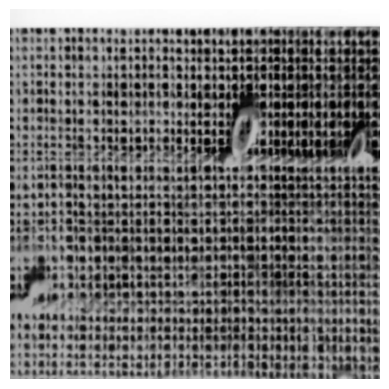

In [20]:

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img_path = '/content/drive/MyDrive/research_pro/own/test/defect/dokuma-746-_jpg.rf.4443d6d743864ac54109cd41b1aeaddb.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))

# Convert image to array and preprocess it
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
prediction = model.predict(img_array)

# Convert prediction to class label
class_label = "defective fabric" if prediction <=0.5 else "good fabric"

print("Predicted Class:", class_label)
# Display the image
imgg = mpimg.imread(img_path)
plt.imshow(imgg)
plt.axis('off')
plt.show()
